### Styling

In [52]:
import vapeplot # https://github.com/dantaki/vapeplot
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["savefig.dpi"] = 300
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle'
    )
# plt.style.use(
#     "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
# )
# plt.style.use("dark_background")
grey = 0.22
# grey = 0.75
# plt.rcParams.update(
#     {
#         "figure.facecolor": (grey, grey, grey, 1.0),
#         "axes.facecolor": (grey, grey, grey, 1.0),
#         "savefig.facecolor": (grey, grey, grey, 1.0),
#         "grid.color": (0.4, 0.4, 0.4, 1.0),
#     }
# )
# vapeplot.set_palette("mallsoft")
plt.set_cmap("plasma");

<Figure size 640x480 with 0 Axes>

Load a checkpoint to generate results

In [4]:
import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(device)

cpu


In [5]:
import h5py
import numpy as np

from storage import upload_to_bucket, download_from_bucket
from schedules import mutate_timeseries
from simulate import BatchSimulator
from schema import Schema

schema = Schema()

c:\Users\zoele\anaconda3\envs\ml-for-bem\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Download the checkpoints

In [ ]:
# download_from_bucket(
#     blob_name=f"models/FINAL-TRAINED-FULL-WEATHER-energy.pt",
#     file_name="./checkpoints/final_model_energy.pt")
# download_from_bucket(
#     blob_name=f"models/FINAL-TRAINED-FULL-WEATHER-timeseries.pt", 
#     file_name="./checkpoints/final_model_timeseries.pt")

Make and load the models

In [6]:
import torch.nn as nn

class EnergyTimeseriesCNNBlockA(nn.Module):
    def __init__(self, 
                 in_channels=11,
                 n_feature_maps = 64,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm1d(n_feature_maps), 
        )

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)

class EnergyTimeseriesCNNBlockB(nn.Module):
    def __init__(self, 
                 in_channels=128,
                 n_feature_maps = 128,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.BatchNorm1d(n_feature_maps)

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)


class AnnualEnergyCNN(nn.Module):
    def __init__(self, 
               out_channels=22,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR ANNUAL
        self.GlobalAveragePool = nn.AvgPool1d(kernel_size=8760) # 1D? average across all feature maps
        self.linear = nn.Linear(in_features=n_feature_maps*2, out_features=out_channels)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.GlobalAveragePool(x)
        x = x.squeeze(-1)
        x = self.linear(x)
        return nn.functional.relu(x)

class MonthlyEnergyCNN(nn.Module):
    def __init__(self, 
               in_channels=8,
               out_channels=8,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR MONTHLY (out is 2x12)
        self.month_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps*2,
                out_channels=out_channels,
                kernel_size=30,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
        )   
        self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.pooling(x)
        x = self.month_convolutional_layer(x)
        return nn.functional.relu(x)
    
class EnergyCNN(torch.nn.Module):
    def __init__(self, 
                 in_channels=30,
                 n_feature_maps=64,
                 out_channels=2
                 ):
        super(EnergyCNN, self).__init__()

        # FOR MONTHLY (out is 2x12)
        self.in_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
            )
        
        self.out_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=out_channels,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
            )  
        # self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, sample):
        # sample (22+n, 1)
        x = self.in_convolutional_layer(sample)
        x = nn.functional.leaky_relu(x)
        x = self.out_convolutional_layer(x)
        x = nn.functional.leaky_relu(x)

        return x

In [7]:
building_vect_schema = [
    'climate_zone', # ADDED CLIMATE ZONE
    'width', 
    'height', 
    'facade_2_footprint', 
    'perim_2_footprint',
    'roof_2_footprint',
    'footprint_2_ground',
    'wwr',
    'orientation',
    'HeatingSetpoint',
    'CoolingSetpoint',
    'LightingPowerDensity',
    'EquipmentPowerDensity',
    'PeopleDensity',
    'Infiltration',
    'FacadeMass',
    'RoofMass',
    'FacadeRValue',
    'RoofRValue',
    'SlabRValue',
    ]

building_vector_size = len(building_vect_schema) + 3 # (area/windowsettings) - CLIMATE ZONE

In [8]:
latent_size = 22
energy_input_size = latent_size + building_vector_size-1
timeseries_model = MonthlyEnergyCNN(out_channels=latent_size).to(device)
energy_model = EnergyCNN(in_channels=energy_input_size).to(device)

In [9]:
timeseries_model.load_state_dict(torch.load("./checkpoints/final_model_timeseries.pt")["model_state_dict"])
timeseries_model.eval()

MonthlyEnergyCNN(
  (resblock_1): EnergyTimeseriesCNNBlockA(
    (input_convolutional_layer): Sequential(
      (0): Conv1d(11, 64, kernel_size=(8,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mid_convolutional_layer): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (final_convolutional_layer): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_layer): Sequential(
      (0): Conv1d(11, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblock_2): EnergyTimeseriesCNNBlockA(
    (input_convolutional_layer): Sequential(
      (0): Conv1d(64, 128,

In [10]:
energy_model.load_state_dict(torch.load("./checkpoints/final_model_energy.pt")["model_state_dict"])
energy_model.eval()

EnergyCNN(
  (in_convolutional_layer): Sequential(
    (0): Conv1d(44, 64, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_convolutional_layer): Sequential(
    (0): Conv1d(64, 2, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### Load climate and schedule arrays

In [39]:
# download_from_bucket(blob_name=f"climate_array.npy", file_name="./data/epws/climate_array.npy")
# download_from_bucket(blob_name=f"tsol.npy", file_name="./data/epws/tsol.npy")
# download_from_bucket(blob_name=f"default_schedules.npy", file_name="./data/template_libs/default_schedules.npy")
# download_from_bucket(blob_name=f"all_data_monthly.hdf5", file_name="./data/hdf5/all_data_monthly.hdf5")

INFO:Storage:Downloading bucket:all_data_monthly.hdf5 to file:./data/hdf5/all_data_monthly.hdf5...
INFO:Storage:Done downloading.


In [11]:
climate_array = np.load("./data/epws/climate_array.npy")
tsol_array = np.load("./data/epws/tsol.npy")
tsol_array = np.load("./data/epws/tsol.npy")
schedules = np.load("./data/template_libs/default_schedules.npy") # 3x8760

### Dataloader

In [12]:
def normalize(data, maxv, minv):
    return (data-minv)/(maxv-minv)

In [13]:
# the loading & preprocessing grouped into a function
def load_training_samples(schema,
    start_idx = 0,
    count = 20000,
    dbt_max = 50.0, # 50.5
    dbt_min = -35.0,
    rh_max = 100.0,
    rh_min = 0.0, # 2.0
    atm_max = 105800.0,
    atm_min = 75600.0,
    rad_min = 0.0,
    ghrad_max = 1200.0, #1154.0
    dnrad_max = 1097.0,
    dhrad_max = 689.0,
    skyt_max = 32.3,
    skyt_min = -58.3,
    tsol_max = 60,
    tsol_min = -40,
    a_max = 2000,
    a_min = 0,
    energy_min = 0,
    energy_max = 30, # 30 kWh/m2/mo
):
    with h5py.File(f"./data/hdf5/all_data_monthly.hdf5", 'r') as f:
        batch_size=count
        monthly = f["monthly"][start_idx:start_idx+batch_size] # this loads the whole batch into memory!
        # total_heating = f["total_heating"][0:batch_size] # this loads the whole batch into memory!
        # total_cooling = f["total_cooling"][0:batch_size] # this loads the whole batch into memory!
        # errors = f["errors"][...]
        area = f["area"][start_idx:start_idx+batch_size]
        batch = f["storage_batch"][start_idx:start_idx+batch_size]
    # Normalize the whole climate and tsol array
    maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
    mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

    norm_climate_array = np.zeros(climate_array.shape)
    norm_tsol_array = np.zeros(tsol_array.shape)
    for j in range(climate_array.shape[0]):
        for i in range(7):
            norm_climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
        for i in range(4):
            norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

    # Schedules
    seeds = schema["schedules_seed"].extract_storage_values_batch(batch).astype(int) # 1x1
    operations_maps = schema["schedules"].extract_storage_values_batch(batch) # 3

    # timeseries_vector = np.zeros((data_size, 8, 8760))
    data_size = batch.shape[0]
    timeseries_vector = np.zeros((data_size, 11, 8760))
    orientations = schema['orientation'].extract_storage_values_batch(batch).flatten()
    idxs = schema['base_epw'].extract_storage_values_batch(batch).flatten()
    # Get the weather file for each entry
    for i, epw_idx in enumerate(idxs):
        epw_idx = int(epw_idx)
        timeseries_vector[i, :-4, :] = norm_climate_array[epw_idx]
        timeseries_vector[i, -4:-1, :] = mutate_timeseries(schedules, operations_maps[i], seeds[i])
        timeseries_vector[i, -1, :] = norm_tsol_array[epw_idx, int(orientations[i]), :]
    wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

    

    building_vector = np.zeros((data_size, building_vector_size))
    for i, schema_name in enumerate(building_vect_schema):
        column = schema[schema_name].extract_storage_values_batch(batch).flatten()
        if schema_name == "climate_zone":
            column = column
            building_vector[:, i] = column
            continue
        try:
            column = normalize(column, schema[schema_name].max, schema[schema_name].min)
        except:
            print(f"Calculating mean from batch data for {schema_name}...")
            column = normalize(column, np.max(column), np.min(column))
        building_vector[:, i] = column
    building_vector[:, -3] = normalize(area, a_max, a_min)
    building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
    building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

    # Add core and perimeter together
    heating = (monthly[:, 0, :]+monthly[:, 2, :]) / area.reshape(-1,1)
    cooling = (monthly[:, 1, :]+monthly[:, 3, :]) / area.reshape(-1,1)
    area_normed_results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

    norm_results = normalize(area_normed_results, energy_max*2.777e7, energy_min*2.777e7)
    # TODO: MAKE THIS EUI?


    return building_vector, timeseries_vector, norm_results

def make_dataset(start_idx, count, loader_batch_size=100):
    torch.cuda.empty_cache()
    building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=count)
    dataset  = {}
    for i in range(building_vector.shape[0]):
        # DICT ENTRIES MUST BE IN ORDER
        dataset[i] = dict({
            "building_vector": np.array([building_vector[i]]*12).T,
            "timeseries_vector": timeseries_vector[i],
            "results_vector": norm_results[i],
        })
    generator = torch.Generator()
    generator.manual_seed(0)

    train, val, test = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=generator)
    training_dataloader = torch.utils.data.DataLoader(train, batch_size=loader_batch_size, shuffle=False)
    validation_dataloader = torch.utils.data.DataLoader(val, batch_size=loader_batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=loader_batch_size, shuffle=False)
    return {"datasets": {"train": train, "test": test, "validate": val}, "dataloaders": {"train": training_dataloader, "test": test_dataloader, "validate": validation_dataloader}}

Run the model

In [14]:
unseen_climates = make_dataset(start_idx=400000, count=20000)
test_dataloader = unseen_climates["dataloaders"]["train"] # fine to use training since it's never been seen

Calculating mean from batch data for orientation...


In [16]:
print("starting projection")
all_loads = []
all_results = []
latent_vectors = []
# epws = []
czs = []
temps = []
losses = []

loss_function = nn.MSELoss()

with torch.no_grad():
    for test_samples in test_dataloader:
        # test_samples = next(iter(test_dataloader))
        timeseries = test_samples["timeseries_vector"].to(device).float()
        bldg_vect = test_samples["building_vector"].to(device).float()
        czs.append(bldg_vect[:, 0, 0])
        bldg_vect = bldg_vect[:, 1:, :]
        loads = test_samples["results_vector"].to(device).float()
        # timeseries[:,:7] = 0
        temp = timeseries[:,0]
        # temp = temp[:,:24*30*12]
        # temp = temp.reshape(-1, 12, 30*24)
        # temp = torch.mean(temp, axis=2)
        temps.append(temp)

        # print("bldg_vect: ", bldg_vect.shape)
        # print("timeseries: ", timeseries.shape)
        # print("loads: ", loads.shape)
        timeseries_latvect = timeseries_model(timeseries)
        # print("latent: ", timeseries_latvect.shape)

        # Concatenate vectors
        x = torch.cat([timeseries_latvect, bldg_vect], axis=1)
        x = x.squeeze(1)
        # print("energy input: ", x.shape)

        predicted_loads = energy_model(x)
        all_loads.append(loads)
        all_results.append(predicted_loads)
        latent_vectors.append(timeseries_latvect)

        loss = loss_function(loads, predicted_loads)
        losses.append(loss)

all_loads = torch.vstack(all_loads)
all_results = torch.vstack(all_results)
# all_losses = torch.vstack(losses)
all_temps = torch.vstack(temps)
latent_vectors = torch.vstack(latent_vectors)

starting projection


In [17]:
czs = torch.vstack(czs)
czs = np.array(czs).reshape(16000)
all_losses = torch.vstack(losses)

In [18]:
print(all_loads.shape)
print(all_results.shape)
print(latent_vectors.shape)
print(czs.shape)
print(all_losses.shape)

torch.Size([16000, 2, 12])
torch.Size([16000, 2, 12])
torch.Size([16000, 22, 12])
(16000,)
torch.Size([160, 1])


In [27]:
import math
print(f"The RMSE for a test set with 20k samples is {round(math.sqrt(all_losses.mean()), 5)}")

The RMSE for a test set with 20k samples is 0.00747


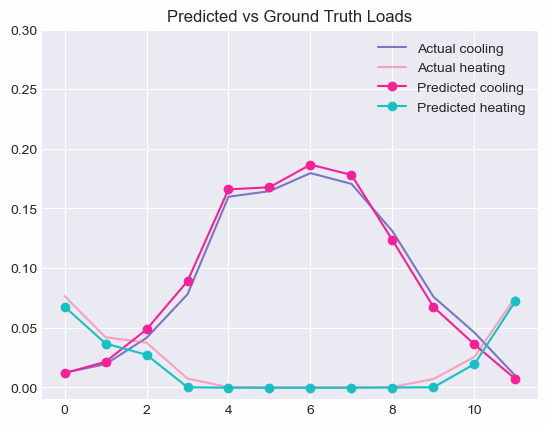

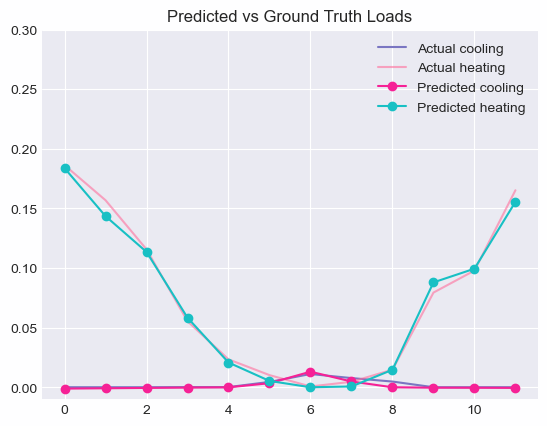

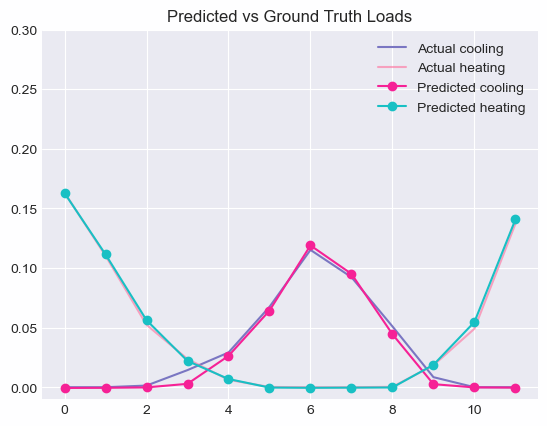

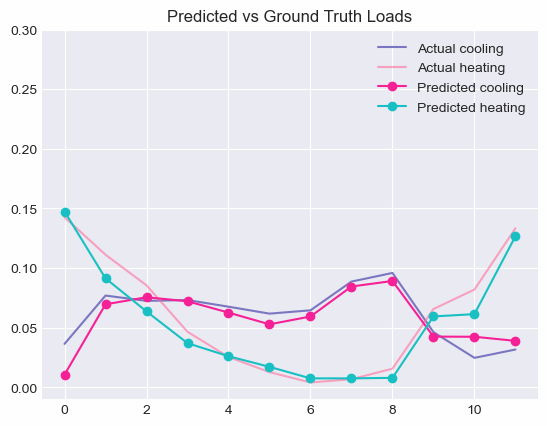

IndexError: index 4 is out of bounds for axis 0 with size 4

In [33]:
np.random.seed(0)
ix = np.random.choice(np.arange(all_loads.shape[0]), 4)
for idx in range(10):
    i = ix[idx]

    # fig, axs = plt.subplots(1,2, figsize=(15,5))
    fig = plt.figure()
    # ax = axs[0].twinx()
    # ax.plot(
    #     all_temps[i,:30*24*12].reshape(12,30*24).mean(axis=1).cpu(),
    #     label="Temp",
    # )
    plt.title("Predicted vs Ground Truth Loads")
    plt.plot(all_loads[i, 1, :].cpu(), label="Actual cooling")
    plt.plot(all_loads[i, 0, :].cpu(), label="Actual heating")
    plt.plot(all_results[i, 1, :].cpu(), "-o",label="Predicted cooling")
    plt.plot(all_results[i, 0, :].cpu(),"-o", label="Predicted heating")
    plt.legend()
    plt.ylim([-0.01,0.3])
    plt.show()

## Visualize output data

Looking first at the latent vectors, as our dataset has many (uninterpretable) dimensions/features (22), but we expect there to be some similarities due to aspects such as climate zone, we use Tsne to visualize the intermediate fingerprints of timeseries latent vectors.

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

flat_fingerprints = np.array(latent_vectors).reshape((16000, 22*12))

pca_embedding = PCA(n_components=10).fit_transform(flat_fingerprints)

In [93]:
pca_embedding.shape

(16000, 10)

In [35]:
embedding_3d = PCA(n_components=2).fit_transform(flat_fingerprints)

(-1.0, 0.0)

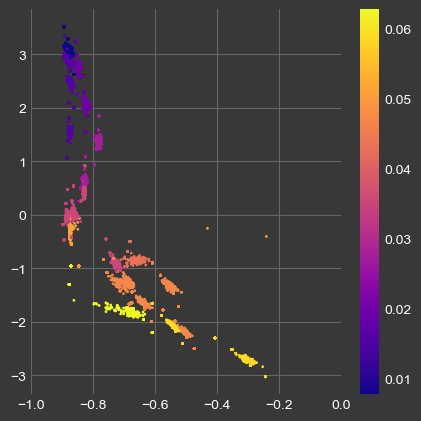

In [104]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_3d[:, 0].tolist(), embedding_3d[:, 1].tolist(), c=colors/255, s=1)
plt.colorbar()
plt.xlim([-1, 0])

In [36]:
perplexity = 1
embedding = TSNE(
    n_components=2, perplexity=perplexity, n_iter=500, init="pca"
    ).fit_transform(flat_fingerprints)

# embedding = TSNE(
#     n_components=2, perplexity=perplexity, n_iter=500, init="pca"
#     ).fit_transform(pca_embedding)

Identify embeddings by climate zone

In [37]:
colors = czs.flatten()

In [40]:
CLIMATEZONES = [
    "0A",
    "0B",
    "1A",
    "1B",
    "2A",
    "2B",
    "3A",
    "3B",
    "3C",
    "4A",
    "4B",
    "4C",
    "5A",
    "5B",
    "5C",
    "6A",
    "6B",
    "7A",
    "8A",
]

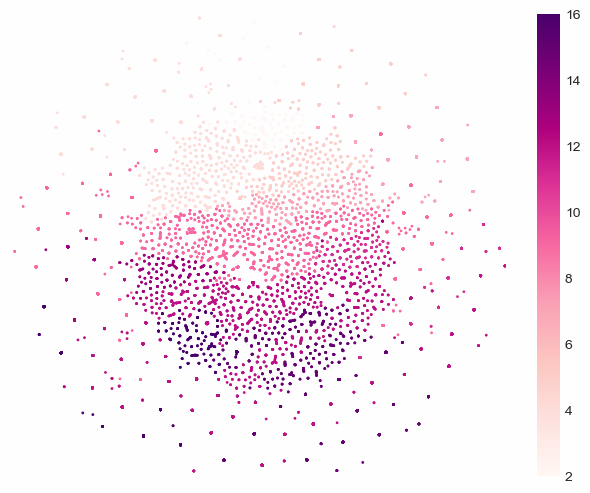

In [51]:
x_min, x_max = min(embedding[:, 0]), max(embedding[:, 0])
y_min, y_max = min(embedding[:, 1]), max(embedding[:, 1])

size = 0.01 * min(x_max-x_min, y_max-y_min)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=1)
# plt.xlim((x_min - size, x_max + size))
plt.xlim((x_min - size, 60))
plt.ylim((y_min - size, y_max + size))
plt.axis("off")
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cb = plt.colorbar()
# cb.set_yticklabels(CLIMATEZONES)  # vertically oriented colorbar
plt.savefig("pcs2.png")
plt.show()


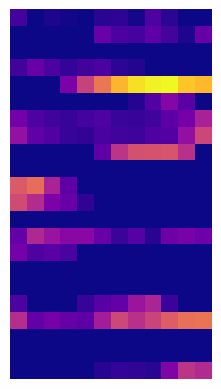

In [57]:
c = CLIMATEZONES.index("1A")
ix = np.random.choice(np.argwhere(czs==c).flatten(), 1)
for i in ix:
    plt.imshow(np.array(latent_vectors[i]))
    # plt.savefig(f"latentv_cz{c}_{i}.png")
    plt.axis("off")
    plt.show()